<a href="https://colab.research.google.com/github/kirbu123/FilmGeneration/blob/develop/FilmGenerationAttemp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import usefull libs

In [ ]:
!pip install setuptools-rust

In [ ]:
!pip install transformers==2.5.1

In [ ]:
!pip install --upgrade diffusers

In [1]:
import torch
import time
from datetime import datetime
from tqdm import tqdm
import pandas as pd
from google.colab import drive
import os
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, KFold
from sklearn.multiclass import OneVsRestClassifier
from PIL import Image
import requests
from io import BytesIO
from bs4 import BeautifulSoup
import pandas as pd
import csv
from urllib.request import urlopen
import multiprocessing

## Load dataset

Go to root

In [5]:
!cd /content

Make data directory, go there

In [6]:
!mkdir laion-high-resolution && cd laion-high-resolution

In [7]:
# Function for loading 100 rows of dataset from the url
# Param filtering indicate filtering of data by languages (langs) when it is filtering = True
# Param filter_lang sorts data from all langs except filter_lang
# Param file_name sets file_name + .csv
def LoadLaionDataset(filtering = False, filter_lang = '', load_csv = False, file_name = 'dataset', url = 'https://huggingface.co/datasets/laion/laion-high-resolution/viewer/default/train'):
  # Created an URL object in url
  # Create object page
  page = requests.get(url)
  # parser-lxml = Change html to Python friendly format
  # Obtain page's information
  soup = BeautifulSoup(page.text, 'lxml')
  # Obtain information from tag <table>
  table = soup.find('table', attrs={"class": "w-full table-auto rounded-lg font-mono text-xs text-gray-900"})
  # Obtain every title of columns with tag <th>
  headers = []
  for i in table.find_all('th'):
    title = i.text
    headers.append(title[:title.find('\n')])
  # Create a dataframe
  df = pd.DataFrame(columns = headers)
  # Create a for loop to fill mydata
  for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [i.text[:i.text.find('\n')] for i in row_data]
    for i in range(len(row)):
      row[i] = row[i][row[i].find('"') + 1: row[i].rfind('"')]
    length = len(df)
    df.loc[length] = row
  # Filtering by languages
  if filtering:
    df = df[df['LANGUAGE'] == filter_lang]
  # Loading .csv
  if load_csv:
    df.to_csv ('/content/laion-high-resolution/' + str(file_name) + '.csv', index= False )
  return df

In [8]:
df = LoadLaionDataset(load_csv = True)

In [9]:
df.head()

,URL,TEXT,WIDTH,HEIGHT,similarity,LANGUAGE,hash,pwatermark,punsafe
0,https://mmedia.ozone.ru/multimedia/1018085734.JP,"Штора рулонная Эскар, цвет: абрикосовый, ширин...","1,02","1,20",0.27589,r,"-3,448,109,611,037,364,00",0.05275,0.00129
1,https://images.squarespace-cdn.com/content/v1/...,Elysia Lounge chair from DeLaEspad,"2,50","1,66",0.29183,nolan,"1,517,529,356,012,770,30",0.05878,0.00001
2,https://images.footballfanatics.com/FFImage/th...,Houston Texans Striped Prime Time Backpac,"2,00","2,00",0.39709,e,"5,924,454,315,519,412,00",nul,nul
3,https://images.squarespace-cdn.com/content/v1/...,©Radiohead-Bandcam,"1,20","1,20",0.26665,nolan,"-3,933,968,474,534,865,40",0.06562,0.00001
4,"https://s3.r29static.com/bin/entry/4ce/0,0,200...",Amazon Registry Best Wedding Gift Item,"2,00","1,05",0.31002,e,"7,893,281,056,273,843,00",0.15549,0.00004


Upgrade of dataset loading function

In [10]:
# Param frames_count sets count of loading url pages
# Other params are same eith previous function
def LoadData(frames_count = 1, filtering = False, filter_lang = '', load_csv = False, file_name = 'dataset', based_url = 'https://huggingface.co/datasets/laion/laion-high-resolution/viewer/default/train'):
  # DataFrame list
  df_list = list()
  # Updating df_list by loading .csv by url
  for i in tqdm(range(frames_count)):
    df_list.append(LoadLaionDataset(filtering, filter_lang, load_csv = False, url = based_url + '?p=' + str(i)))
  # concating df_list to one big DataFrame
  result_df = pd.concat(df_list)
  X = result_df[['TEXT', 'LANGUAGE']].to_numpy()
  y = result_df['URL'].to_numpy()
  return result_df, list([X, y])

In [11]:
df, dataset = LoadData(frames_count = 1)

100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


In [12]:
len(df)

100

In [13]:
df.head()

,URL,TEXT,WIDTH,HEIGHT,similarity,LANGUAGE,hash,pwatermark,punsafe
0,https://mmedia.ozone.ru/multimedia/1018085734.JP,"Штора рулонная Эскар, цвет: абрикосовый, ширин...","1,02","1,20",0.27589,r,"-3,448,109,611,037,364,00",0.05275,0.00129
1,https://images.squarespace-cdn.com/content/v1/...,Elysia Lounge chair from DeLaEspad,"2,50","1,66",0.29183,nolan,"1,517,529,356,012,770,30",0.05878,0.00001
2,https://images.footballfanatics.com/FFImage/th...,Houston Texans Striped Prime Time Backpac,"2,00","2,00",0.39709,e,"5,924,454,315,519,412,00",nul,nul
3,https://images.squarespace-cdn.com/content/v1/...,©Radiohead-Bandcam,"1,20","1,20",0.26665,nolan,"-3,933,968,474,534,865,40",0.06562,0.00001
4,"https://s3.r29static.com/bin/entry/4ce/0,0,200...",Amazon Registry Best Wedding Gift Item,"2,00","1,05",0.31002,e,"7,893,281,056,273,843,00",0.15549,0.00004


In [14]:
dataset[0][0]

array(['Штора рулонная Эскар, цвет: абрикосовый, ширина 140 см, высота 170 см81012140170Рулонными шторами Эскар можно оформлять окна как самостоятельно, так и использовать в комбинации с портьерами. Это поможет предотвратить выгорание дорогой ткани на солнце и соединит функционал рулонных с красотой навесных. Преимущества применения рулонных штор для пластиковых окон: - имеют прекрасный внешний вид: многообразие и фактурность материала изделия отлично смотрятся в любом интерьере;- многофункциональны: есть возможность подобрать шторы способные эффективно защитить комнату от солнца, при этом она не будет слишком темной;- есть возможность осуществить быстрый монтаж.ВНИМАНИЕ! Размеры ширины изделия указаны по ширине ткани! Во время эксплуатации не рекомендуется полностью разматывать рулон, чтобы не оторвать ткань от намоточного вала. В случае загрязнения поверхности ткани, чистку шторы проводят одним из способов, в зависимости от типа загрязнения:легкое поверхностное загрязнение можно удал

## KFold sampling on train-test split



In [15]:
# This func makes KFold from Sklearn more convinient to out task
def KFoldSampling(dataset, nsplits):
  # X, y split from dataset
  X, y = dataset[0], dataset[1]
  kf = KFold(n_splits = nsplits)
  kf.get_n_splits()
  # list of indicies of KFold
  result = list()
  for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    # Appending train-test indicies ro result list
    result.append(np.array([train_index, test_index]))
  return np.array(result)

In [16]:
KFoldSampling(dataset, nsplits=2)

2it [00:00, 927.53it/s]


array([[[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
         66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
         82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
         98, 99],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
         32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
         48, 49]],

       [[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
         32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
         48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
         66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
         82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
         98, 99]]])

## Dataset transform from url to image

In [17]:
# Function for loading image
def LoadImageMulti(url, queue):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  queue.put(img)

# Safe loading of image with time limit

def LineStop(target, arg, time_limit = 10):
  queue = multiprocessing.Queue()
  p = multiprocessing.Process(target=target, args=(arg, queue))
  p.start()
  p.join(time_limit)
  if p.is_alive():
    print('ABORT')
    # Terminate
    p.terminate()
    return
  return queue.get()

LineStop(LoadImageMulti, 'https://mmedia.ozone.ru/multimedia/1018085734.JPG')

ABORT


In [19]:
def DatasetTransform(dataset, image_dir = '', time_limit = 10, all_time_limit = 1000):
  # Making directory for dataset
  if image_dir:
    if image_dir[len(image_dir) - 1] == '/':
      image_dir = image_dir[:len(image_dir) - 1]
    os.environ["DIRECTORY_NAME"] = image_dir
    !mkdir -p ${DIRECTORY_NAME}
  # Making X, y from dataset
  X = dataset[0]
  y = dataset[1]
  # Making result lists
  result_y = list()
  result_X = list()
  # Start time
  start_time = datetime.now()

  for i, url in enumerate(tqdm(y)):
    # All exceptions are ignored
    try:
      # Load image
      response = requests.get(url)
      img = Image.open(BytesIO(response.content))
      if image_dir:
        print(image_dir + '/image_' + str(i) + '.jpg')
        img.save(image_dir + '/image_' + str(i) + '.jpg')
    except Exception:
      continue
    # Appending numpy image
    result_y.append(np.array(img))
    result_X.append(X[i])
    # Checking time break
    if (datetime.now() - start_time).seconds > all_time_limit:
      print('Time break')
      return list([np.array(result_X), np.array(result_y)])
  return list([np.array(result_X), np.array(result_y)])

In [20]:
DatasetTransform(dataset, image_dir='/content/data_images', all_time_limit = 30)

  2%|▏         | 2/100 [00:01<00:56,  1.75it/s]

/content/data_images/image_1.jpg


  3%|▎         | 3/100 [00:11<07:43,  4.78s/it]

/content/data_images/image_2.jpg


  4%|▍         | 4/100 [00:11<04:51,  3.03s/it]

/content/data_images/image_3.jpg


  6%|▌         | 6/100 [00:12<02:22,  1.52s/it]

/content/data_images/image_5.jpg


  9%|▉         | 9/100 [00:14<01:32,  1.02s/it]

/content/data_images/image_8.jpg


 10%|█         | 10/100 [00:14<01:14,  1.22it/s]

/content/data_images/image_9.jpg


 12%|█▏        | 12/100 [00:16<01:00,  1.46it/s]

/content/data_images/image_11.jpg


 13%|█▎        | 13/100 [00:16<00:50,  1.73it/s]

/content/data_images/image_12.jpg


 16%|█▌        | 16/100 [00:20<01:34,  1.13s/it]

/content/data_images/image_15.jpg


 18%|█▊        | 18/100 [00:22<01:24,  1.03s/it]

/content/data_images/image_17.jpg


 23%|██▎       | 23/100 [00:35<04:34,  3.57s/it]<ipython-input-19-4fde11e43845>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return list([np.array(result_X), np.array(result_y)])
 23%|██▎       | 23/100 [00:35<01:58,  1.54s/it]

/content/data_images/image_23.jpg
Time break


[array([['Elysia Lounge chair from DeLaEspad', 'nolan'],
        ['Houston Texans Striped Prime Time Backpac', 'e'],
        ['©Radiohead-Bandcam', 'nolan'],
        ['Gurneys Star Island Wedding Photo', 'nolan'],
        ['Masjid Fundraising Campaign Dinner – 11th May Updat', 'e'],
        ["Forbidden Island's menu..", 'nolan'],
        ['117 Evergreen, Kirkland, Illinois, 6014', 'f'],
        ['Students on the Walk of the Gods located on the Amalfi Coast (Photo: Canisius College',
         'e'],
        ['A4-Whitepaper-CitizenDevelopers-skill-ladder-', 'e'],
        ['Total War Warhammer Wallpaper Hd Artstation Centipede Mountain Chen Ziy',
         'nolan'],
        ['large scale helicopter prin', 'e']], dtype=object),
 array([array([[[238, 238, 238],
                [238, 238, 238],
                [238, 238, 238],
                ...,
                [238, 238, 238],
                [238, 238, 238],
                [238, 238, 238]],
 
               [[238, 238, 238],
             

## SDXL PART

Downloading & Importing smth

In [21]:
!pip install --upgrade safetensors

In [22]:
!pip install transformers

In [23]:
!pip install huggingface_hub

In [24]:
!pip install --upgrade diffusers

In [31]:
from huggingface_hub import snapshot_download
from diffusers import DiffusionPipeline, StableDiffusionXLImg2ImgPipeline

## SDXL with Finetuning

Example pictures dataset

In [3]:
local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/content/dog'

In [25]:
#@title 🤗 AutoTrain DreamBooth
#@markdown In order to use this colab
#@markdown - upload images to a folder named `images/`
#@markdown - choose a project name if you wish
#@markdown - change model if you wish, you can also select sd2/2.1 or sd1.5
#@markdown - update prompt and remember it. choose keywords that don't usually appear in dictionaries
#@markdown - add huggingface information (token and repo_id) if you wish to push trained model to huggingface hub
#@markdown - update hyperparameters if you wish
#@markdown - click `Runtime > Run all` or run each cell individually

!pip install -U autotrain-advanced > install_logs.txt
!autotrain setup > setup_logs.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.23.4 which is incompatible.
> INFO    Installing latest transformers@main
> INFO    Successfully installed latest transformers
> INFO    Installing latest peft@main
> INFO    Successfully installed latest peft
> INFO    Installing latest diffusers@main
> INFO    Successfully installed latest diffusers
> INFO    Installing latest trl@main
> INFO    Successfully installed latest trl
> INFO    Installing latest xformers
> INFO    Successfully installed latest xformers


In [26]:
#@markdown ---
#@markdown #### Project Config
project_name = 'fine_tuned_model' # @param {type:"string"}
dataset_dir = '/content/data_images' # @param {type: "string"}
model_name = 'runwayml/stable-diffusion-v1-5' # @param ["stabilityai/stable-diffusion-xl-base-1.0", "runwayml/stable-diffusion-v1-5", "stabilityai/stable-diffusion-2-1", "stabilityai/stable-diffusion-2-1-base"]
prompt = 'photo of a sks dog' # @param {type: "string"}


#@markdown ---
#@markdown #### Push to Hub?
#@markdown Use these only if you want to push your trained model to a private repo in your Hugging Face Account
#@markdown If you dont use these, the model will be saved in Google Colab and you are required to download it manually.
#@markdown Please enter your Hugging Face write token. The trained model will be saved to your Hugging Face account.
#@markdown You can find your token here: https://huggingface.co/settings/tokens
push_to_hub = False # @param ["False", "True"] {type:"raw"}
hf_token = "hf_XXX" #@param {type:"string"}
repo_id = "username/repo_name" #@param {type:"string"}

#@markdown ---
#@markdown #### Hyperparameters
learning_rate = 1e-4 # @param {type:"number"}
num_steps = 10 #@param {type:"number"}
batch_size = 1 # @param {type:"slider", min:1, max:32, step:1}
gradient_accumulation = 4 # @param {type:"slider", min:1, max:32, step:1}
resolution = 1024 # @param {type:"slider", min:128, max:1024, step:128}
use_8bit_adam = True # @param ["False", "True"] {type:"raw"}
use_xformers = True # @param ["False", "True"] {type:"raw"}
use_fp16 = True # @param ["False", "True"] {type:"raw"}
train_text_encoder = False # @param ["False", "True"] {type:"raw"}
gradient_checkpointing = True # @param ["False", "True"] {type:"raw"}

os.environ["PROJECT_NAME"] = project_name
os.environ["DATASET_DIR"] = dataset_dir
os.environ["MODEL_NAME"] = model_name
os.environ["PROMPT"] = prompt
os.environ["PUSH_TO_HUB"] = str(push_to_hub)
os.environ["HF_TOKEN"] = hf_token
os.environ["REPO_ID"] = repo_id
os.environ["LEARNING_RATE"] = str(learning_rate)
os.environ["NUM_STEPS"] = str(num_steps)
os.environ["BATCH_SIZE"] = str(batch_size)
os.environ["GRADIENT_ACCUMULATION"] = str(gradient_accumulation)
os.environ["RESOLUTION"] = str(resolution)
os.environ["USE_8BIT_ADAM"] = str(use_8bit_adam)
os.environ["USE_XFORMERS"] = str(use_xformers)
os.environ["USE_FP16"] = str(use_fp16)
os.environ["TRAIN_TEXT_ENCODER"] = str(train_text_encoder)
os.environ["GRADIENT_CHECKPOINTING"] = str(gradient_checkpointing)

In [27]:
!autotrain dreambooth \
--model ${MODEL_NAME} \
--project-name ${PROJECT_NAME} \
--image-path ${DATASET_DIR} \
--prompt "${PROMPT}" \
--resolution ${RESOLUTION} \
--batch-size ${BATCH_SIZE} \
--num-steps ${NUM_STEPS} \
--gradient-accumulation ${GRADIENT_ACCUMULATION} \
--lr ${LEARNING_RATE} \
$( [[ "$USE_FP16" == "True" ]] && echo "--fp16" ) \
$( [[ "$USE_XFORMERS" == "True" ]] && echo "--xformers" ) \
$( [[ "$TRAIN_TEXT_ENCODER" == "True" ]] && echo "--train-text-encoder" ) \
$( [[ "$USE_8BIT_ADAM" == "True" ]] && echo "--use-8bit-adam" ) \
$( [[ "$GRADIENT_CHECKPOINTING" == "True" ]] && echo "--gradient-checkpointing" ) \
$( [[ "$PUSH_TO_HUB" == "True" ]] && echo "--push-to-hub --token ${HF_TOKEN} --repo-id ${REPO_ID}" )

> INFO    Namespace(version=False, model='runwayml/stable-diffusion-v1-5', revision=None, tokenizer=None, image_path='/content/data_images', class_image_path=None, prompt='photo of a sks dog', class_prompt=None, num_class_images=100, class_labels_conditioning=None, prior_preservation=None, prior_loss_weight=1.0, project_name='fine_tuned_model', seed=42, resolution=1024, center_crop=None, train_text_encoder=None, batch_size=1, sample_batch_size=4, epochs=1, num_steps=10, checkpointing_steps=100000, resume_from_checkpoint=None, gradient_accumulation=4, gradient_checkpointing=True, lr=0.0001, scale_lr=None, scheduler='constant', warmup_steps=0, num_cycles=1, lr_power=1.0, dataloader_num_workers=0, use_8bit_adam=True, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08, max_grad_norm=1.0, allow_tf32=None, prior_generation_precision=None, local_rank=-1, xformers=True, pre_compute_text_embeddings=None, tokenizer_max_length=None, text_encoder_use_attention_mask=None, 

In [29]:
def ImageFromPrompt(prompt, weight_name="pytorch_lora_weights.safetensors", project_name=project_name, model=model_name):
  prj_path = "/content/" + str(project_name)
  pipe = DiffusionPipeline.from_pretrained(
      model,
      torch_dtype=torch.float16,
  )
  pipe.to("cuda")
  pipe.load_lora_weights(prj_path, weight_name="pytorch_lora_weights.safetensors")

  refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
      "stabilityai/stable-diffusion-xl-refiner-1.0",
      torch_dtype=torch.float16,
  )
  refiner.to("cuda")

  seed = 42
  generator = torch.Generator("cuda").manual_seed(seed)
  image = pipe(prompt=prompt, generator=generator).images[0]
  image_upgrade = refiner(prompt=prompt, generator=generator, image=image).images[0]
  return image, image_upgrade

In [32]:
img, img_upgrade = ImageFromPrompt('A photo of a boy, walking on the street with a ball')

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

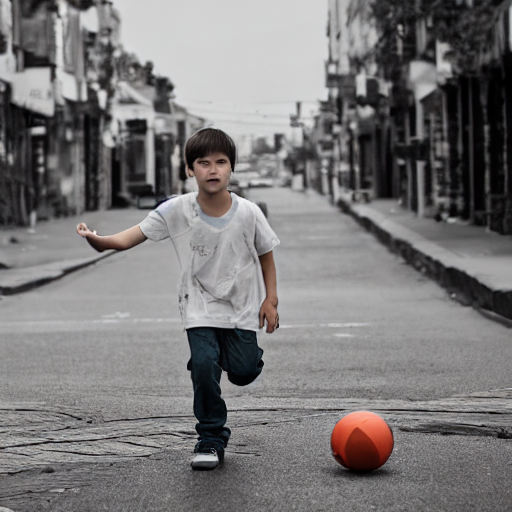

In [33]:
img

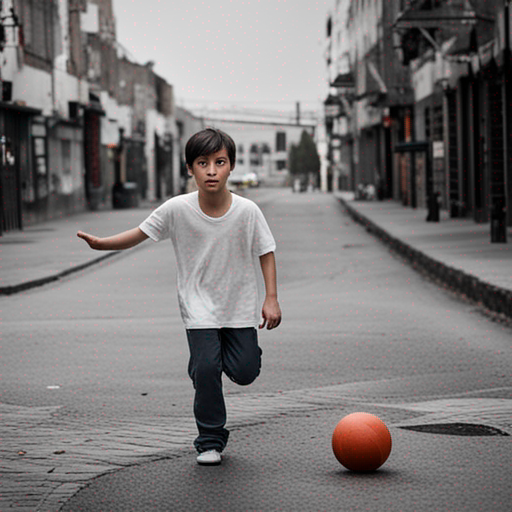

In [34]:
img_upgrade